In [1]:
import torch
import numpy as np
import scipy as sp
from numpy import ndarray 
from typing import Any, Callable, Dict, List, Optional, Tuple, Union, cast
import math
import matplotlib as plt
import scipy.constants


In [2]:
# RANDOM EXAMPLE
x = torch.tensor([1], requires_grad=True, dtype=torch.float)
y = torch.tensor([2], requires_grad=True, dtype=torch.float)

z = x**2 + y**3
z.backward()
print(x.grad)
print(y.grad)

tensor([2.])
tensor([12.])


In [3]:
#FUNCTIONS

#OPERATORS

def annihilation(dimension: int) -> ndarray:
    """
    Returns a dense matrix of size dimension x dimension representing the annihilation
    operator in number basis.
    """
    offdiag_elements = np.sqrt(range(1, dimension))
    return np.diagflat(offdiag_elements, 1)

def creation(dimension: int) -> ndarray:
    """
    Returns a dense matrix of size dimension x dimension representing the creation
    operator in number basis.
    """
    return annihilation(dimension).T




In [4]:
#MORE NOISE RELATED FUNCTIONS



#SOME GLOBAL PARAMETERS
R_k = sp.constants.h / (sp.constants.e**2.0)
R_0 = 50
T = 0.015
M = 400
Delta = 3.4e-4
x_qp = 3e-6

omega_low = 1e-9 * 2 * np.pi
omega_high = 3 * 2 * np.pi
t_exp = 1e4
A_flux = 1e-6
A_cc = 1e-7

#T1 CAPACITIVE
import scipy as sp
import scipy.constants

def q_cap_fun(omega) -> torch.Tensor:
    return (
        1e6
        * (2 * np.pi * 6e9 / torch.abs(omega)) ** 0.7
    )

def calc_therm_ratio(
    omega: float, T: float
) -> torch.Tensor:
    return (sp.constants.hbar * omega) / (sp.constants.k * T)

def spectral_density_cap(omega,EJ,EC,EL,flux):
    
    therm_ratio = calc_therm_ratio(omega, T)
    s = (
        2
        * 8
        * EC
        / q_cap_fun(omega)
        * (1 / torch.tanh(0.5 * torch.abs(therm_ratio)))
        / (1 + torch.exp(-therm_ratio))
    )
    s *= (
        2 * np.pi
    )  # We assume that system energies are given in units of frequency
    return s



In [5]:
#MORE NOISE RELATED FUNCTIONS

#T1 CHARGE IMPEDANCE

def spectral_density_ci(omega,EJ,EC,EL,flux):
    # Note, our definition of Q_c is different from Zhang et al (2020) by a
    # factor of 2

    Q_c = R_k / (8 * np.pi * complex(R_0).real)
    therm_ratio = calc_therm_ratio(omega, T)
    s = (
        2
        * ( omega / 1e9 ) #annoying unit stuff - gotta convert back to GHz
        / Q_c
        * (1 / torch.tanh(0.5 * therm_ratio))
        / (1 + torch.exp(-therm_ratio))
    )
    return s

# T1 FLUX BIAS LINE

def spectral_density_fbl(omega,EJ,EC,EL,flux):
    """
    Our definitions assume that the noise_op is dH/dflux.
    """

    therm_ratio = calc_therm_ratio(omega, T)

    s = (
        2
        * (2 * np.pi) ** 2
        * M**2
        * ( omega / 1e9 ) #annoying unit stuff - gotta convert back to GHz
        * sp.constants.hbar
        / complex(R_0).real
        * (1 / torch.tanh(0.5 * therm_ratio))
        / (1 + torch.exp(-therm_ratio))
    )
    # We assume that system energies are given in units of frequency and that
    # the noise operator to be used with this `spectral_density` is dH/dflux.
    # Hence we have to convert  2 powers of frequency to standard units
    s *= 1e9 ** 2.0
    return s



In [6]:
#T1 INDUCTIVE

def q_ind_fun(omega):

    therm_ratio = abs(calc_therm_ratio(omega, T))
    therm_ratio_500MHz = calc_therm_ratio(
        torch.tensor(2 * np.pi * 500e6), T
    )
    
    return (
        500e6
        * (
            torch.special.scaled_modified_bessel_k0(1 / 2 * therm_ratio_500MHz)
            * torch.sinh(1 / 2 * therm_ratio_500MHz)
            / torch.exp(1 / 2 * therm_ratio_500MHz)
        )
        / (
            torch.special.scaled_modified_bessel_k0(1 / 2 * therm_ratio)
            * torch.sinh(1 / 2 * therm_ratio)
            / torch.exp(1 / 2 * therm_ratio)
        )
    )

def spectral_density_ind(omega,EJ,EC,EL,flux):

    therm_ratio = calc_therm_ratio(omega,T)
    s = (
        2
        * EL
        / q_ind_fun(omega)
        * (1 / torch.tanh(0.5 * torch.abs(therm_ratio)))
        / (1 + torch.exp(-therm_ratio))
    )
    s *= (
        2 * np.pi
    )  # We assume that system energies are given in units of frequency
    return s

In [7]:
# T1 quasiparticle tunneling

def y_qp_fun(omega,EJ,EC,EL,flux):
    """
    Based on Eq. S23 in the appendix of Smith et al (2020).
    """
    # Note that y_qp_fun is always symmetric in omega, i.e. In Smith et al 2020,
    # we essentially have something proportional to sinh(omega)/omega
    omega = torch.abs(omega)
    Delta_in_Hz = Delta * sp.constants.e / sp.constants.h

    omega_in_Hz = omega / (2 * np.pi) 
    EJ_in_Hz = EJ * 1e9 # GHz to Hz

    therm_ratio = calc_therm_ratio(omega, T)
    Delta_over_T = calc_therm_ratio(
        2 * np.pi * Delta_in_Hz, T
    )

    re_y_qp = (
        np.sqrt(2 / np.pi)
        * (8 / R_k)
        * (EJ_in_Hz / Delta_in_Hz)
        * (2 * Delta_in_Hz / omega_in_Hz) ** (3 / 2)
        * x_qp
        * torch.sqrt(1 / 2 * therm_ratio)
        * torch.special.scaled_modified_bessel_k0(1 / 2 * torch.abs(therm_ratio))
        * torch.sinh(1 / 2 * therm_ratio)
        / torch.exp(1 / 2 * torch.abs(therm_ratio))
    )

    return re_y_qp

def spectral_density_qt(omega,EJ,EC,EL,flux):
    """Based on Eq. 19 in Smith et al (2020)."""
    therm_ratio = calc_therm_ratio(omega, T)

    return (
        2
        * omega / 1e9
        * complex(y_qp_fun(omega,EJ,EC,EL,flux)).real
        * (1 / torch.tanh(0.5 * therm_ratio))
        / (1 + torch.exp(-therm_ratio))
    )

In [8]:
#GENERAL T1 function

def t1(
        noise_op: torch.Tensor,
        spectral_density: Callable,
        eigvals: torch.Tensor,
        eigvecs: torch.Tensor,
        EJ: torch.Tensor,
        EC: torch.Tensor,
        EL: torch.Tensor,
        flux: torch.Tensor,
        i: int = 1,
        j: int = 0
    ):

        # We assume that the energies in `evals` are given in the units of frequency
        # and *not* angular frequency. The function `spectral_density` is assumed to
        # take as a parameter an angular frequency, hence we have to convert.


        ground = eigvecs[:,j]
        excited = eigvecs[:,i]
        ground_E = eigvals[j]
        excited_E = eigvals[i]

        omega = 2 * np.pi * (excited_E - ground_E) * 1e9

        s = (
            spectral_density(omega,EJ,EC,EL,flux) + spectral_density(-omega,EJ,EC,EL,flux)
        )
        
        rate = torch.matmul(noise_op,ground.unsqueeze(0).T)
        rate = torch.matmul(excited.unsqueeze(0).conj(),rate)
        rate = torch.abs(rate) **2 * s
        #print(torch.abs(torch.matmul(excited.unsqueeze(0).conj(),torch.matmul(noise_op,ground.unsqueeze(0).T))))

        return rate

In [9]:
# GENERAL TPHI FUNCTION

def tphi_1_over_f(
        A_noise: float,
        noise_op: torch.Tensor,
        eigvals: torch.Tensor,
        eigvecs: torch.Tensor,
        i: int = 1,
        j: int = 0
    ) -> float:

        ground = eigvecs[:,j]
        excited = eigvecs[:,i]
        ground_E = eigvals[j]
        excited_E = eigvals[i]

        rate = torch.abs(
            torch.matmul(ground.unsqueeze(0).conj(),torch.matmul(noise_op,ground.unsqueeze(0).T))
            - torch.matmul(excited.unsqueeze(0).conj(),torch.matmul(noise_op,excited.unsqueeze(0).T))
        )
        
        rate *= A_noise * np.sqrt(2 * np.abs(np.log(omega_low * t_exp)))

        # We assume that the system energies are given in units of frequency and
        # not the angular frequency, hence we have to multiply by `2\pi`
        rate *= 2 * np.pi

        return rate

In [10]:
# T1 FOR FLUXONIUM
def t1_effective (
    EJ: torch.Tensor,
    EC: torch.Tensor,
    EL: torch.Tensor,
    flux: torch.Tensor,
    dim: float,
):
    
    # PART 1 - GET HAMILTONIAN
    plasma_energy = math.sqrt(8.0*EL*EC)
    diag_elements = [(i + 0.5) for i in range(dim)]
    lc_osc = torch.tensor(np.diag(diag_elements),dtype=torch.double)
    lc_osc = lc_osc * plasma_energy

    phi_osc = (8.0 * EC / EL) ** 0.25
    phi = (
            (torch.tensor(creation(dim),dtype=torch.double) + torch.tensor(annihilation(dim),dtype=torch.double))
            * phi_osc/ math.sqrt(2)
        )

    argument = phi + 2 * np.pi * flux * torch.tensor(np.eye(dim),dtype=torch.double)

    cos_phi = (torch.linalg.matrix_exp(argument*1j)+torch.linalg.matrix_exp(argument*-1j))/2
    sin_phi = (torch.linalg.matrix_exp(argument*1j)-torch.linalg.matrix_exp(argument*-1j))/2j

    n_op = (
                1j
                * (torch.tensor(creation(dim),dtype=torch.double) - torch.tensor(annihilation(dim),dtype=torch.double))
                / (phi_osc * math.sqrt(2))
            )

    d_ham_d_flux = -2 * np.pi * EJ * sin_phi

    H = lc_osc - EJ*cos_phi
    #H = torch.triu(H, diagonal=1).T + torch.triu(H)
    #H.to(torch.double)

    #PART 2 - Get eigenvalues

    eigvals,eigvecs = torch.linalg.eigh(H,UPLO='U')

    # PART 3 - Find rate

    t1_rate = torch.zeros([1,1],dtype=torch.double)

    #3.1 t1_capacitive

    t1_rate += t1(n_op, spectral_density_cap, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.2 t1_charge_impedance

    #t1_rate += t1(n_op, spectral_density_ci, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.3 t1_flux_bias_line

    t1_rate += t1(d_ham_d_flux, spectral_density_fbl, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.4 t1_inductive

    t1_rate += t1(phi.to(torch.cdouble), spectral_density_ind, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.5 t1_quasiparticle_tunneling - a little dubious

    qt_argument = argument/2
    qt_noise = (torch.linalg.matrix_exp(qt_argument*1j)-torch.linalg.matrix_exp(qt_argument*-1j))/2j

    t1_rate += t1(qt_noise.to(torch.cdouble), spectral_density_qt, eigvals, eigvecs, EJ, EC, EL, flux)

    # PART 4 - Get time

    T1 = 1/t1_rate

    return T1

In [16]:
# T2 FOR FLUXONIUM
def t2_effective (
    EJ: torch.Tensor,
    EC: torch.Tensor,
    EL: torch.Tensor,
    flux: torch.Tensor,
    dim: float,
):
    
    # PART 1 - GET HAMILTONIAN
    plasma_energy = math.sqrt(8.0*EL*EC)
    diag_elements = [(i + 0.5) for i in range(dim)]
    lc_osc = torch.tensor(np.diag(diag_elements),dtype=torch.double)
    lc_osc = lc_osc * plasma_energy

    phi_osc = (8.0 * EC / EL) ** 0.25
    phi = (
            (torch.tensor(creation(dim),dtype=torch.double) + torch.tensor(annihilation(dim),dtype=torch.double))
            * phi_osc/ math.sqrt(2)
        )

    argument = phi + 2 * np.pi * flux * torch.tensor(np.eye(dim),dtype=torch.double)

    cos_phi = (torch.linalg.matrix_exp(argument*1j)+torch.linalg.matrix_exp(argument*-1j))/2
    sin_phi = (torch.linalg.matrix_exp(argument*1j)-torch.linalg.matrix_exp(argument*-1j))/2j

    n_op = (
                1j
                * (torch.tensor(creation(dim),dtype=torch.double) - torch.tensor(annihilation(dim),dtype=torch.double))
                / (phi_osc * math.sqrt(2))
            )

    d_ham_d_flux = -2 * np.pi * EJ * sin_phi
    d_ham_d_EJ = - cos_phi


    H = lc_osc - EJ*cos_phi
    #H = torch.triu(H, diagonal=1).T + torch.triu(H)
    #H.to(torch.double)

    #PART 2 - Get eigenvalues

    eigvals,eigvecs = torch.linalg.eigh(H)

    # PART 3 - Find rate from T1

    t2_rate = torch.zeros([1,1],dtype=torch.double)

    #3.1 t1_capacitive

    t2_rate += 0.5 * t1(n_op, spectral_density_cap, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.2 t1_charge_impedance

    #t2_rate += 0.5 * t1(n_op, spectral_density_ci, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.3 t1_flux_bias_line

    t2_rate += 0.5 * t1(d_ham_d_flux, spectral_density_fbl, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.4 t1_inductive

    t2_rate += 0.5 * t1(phi.to(torch.cdouble), spectral_density_ind, eigvals, eigvecs, EJ, EC, EL, flux)

    #3.5 t1_quasiparticle_tunneling - a little dubious

    qt_argument = argument/2
    qt_noise = (torch.linalg.matrix_exp(qt_argument*1j)-torch.linalg.matrix_exp(qt_argument*-1j))/2j

    t2_rate += 0.5 * t1(qt_noise.to(torch.cdouble), spectral_density_qt, eigvals, eigvecs, EJ, EC, EL, flux)

    # PART 4 - Find rate from Tphi

    #4.1 tphi_1_over_f_flux

    t2_rate += tphi_1_over_f(A_flux, d_ham_d_flux, eigvals, eigvecs)
    
    #4.2 tphi_1_over_f_cc

    t2_rate += tphi_1_over_f(A_cc, d_ham_d_EJ, eigvals, eigvecs)

    # PART 5 - Get time

    T2 = 1/t2_rate

    return T2

In [13]:
# Tphi FOR FLUXONIUM
def tphi_effective (
    EJ: torch.Tensor,
    EC: torch.Tensor,
    EL: torch.Tensor,
    flux: torch.Tensor,
    dim: float,
):
    
    # PART 1 - GET HAMILTONIAN
    plasma_energy = math.sqrt(8.0*EL*EC)
    diag_elements = [(i + 0.5) for i in range(dim)]
    lc_osc = torch.tensor(np.diag(diag_elements),dtype=torch.double)
    lc_osc = lc_osc * plasma_energy

    phi_osc = (8.0 * EC / EL) ** 0.25
    phi = (
            (torch.tensor(creation(dim),dtype=torch.double) + torch.tensor(annihilation(dim),dtype=torch.double))
            * phi_osc/ math.sqrt(2)
        )

    argument = phi + 2 * np.pi * flux * torch.tensor(np.eye(dim),dtype=torch.double)

    cos_phi = (torch.linalg.matrix_exp(argument*1j)+torch.linalg.matrix_exp(argument*-1j))/2
    sin_phi = (torch.linalg.matrix_exp(argument*1j)-torch.linalg.matrix_exp(argument*-1j))/2j

    n_op = (
                1j
                * (torch.tensor(creation(dim),dtype=torch.double) - torch.tensor(annihilation(dim),dtype=torch.double))
                / (phi_osc * math.sqrt(2))
            )

    d_ham_d_flux = -2 * np.pi * EJ * sin_phi
    d_ham_d_EJ = - cos_phi


    H = lc_osc - EJ*cos_phi
    #H = torch.triu(H, diagonal=1).T + torch.triu(H)
    #H.to(torch.double)

    #PART 2 - Get eigenvalues

    eigvals,eigvecs = torch.linalg.eigh(H,UPLO='U')

    # PART 3 - Find rate from Tphi

    tphi_rate = torch.zeros([1,1],dtype=torch.double)

    #3.1 tphi_1_over_f_flux

    tphi_rate += tphi_1_over_f(A_flux, d_ham_d_flux, eigvals, eigvecs)
    
    #3.2 tphi_1_over_f_cc

    tphi_rate += tphi_1_over_f(A_cc, d_ham_d_EJ, eigvals, eigvecs)

    # PART 5 - Get time

    Tphi = 1/tphi_rate

    return Tphi

In [24]:
#TENSORS

# INPUT

#default values
#EJ = torch.tensor([8.9], requires_grad=True, dtype=torch.double)
#EC = torch.tensor([2.5], requires_grad=True, dtype=torch.double)
#EL = torch.tensor([0.5], requires_grad=True, dtype=torch.double)
#flux = torch.tensor([0.5], requires_grad=True, dtype=torch.double)

#random values
EJ = torch.rand(1, requires_grad=True, dtype=torch.double)
EC = torch.rand(1, requires_grad=True, dtype=torch.double)
EL = torch.rand(1, requires_grad=True, dtype=torch.double)
flux = torch.tensor([0.5], requires_grad=True, dtype=torch.double)

EJ.data = EJ.data * (20 - 2.5) + 2.5
EC.data = EC.data * (8 - 1e-3) + 1e-3
EL.data = EL.data * (10 - 2e-1) + 2e-1

# PARAMETERS

dim = 110

learn_rate = 5e2

# BOUNDS

EJ_bounds = [2.5, 150]
EC_bounds = [1e-3, 8]
EL_bounds = [2e-1, 10]
flux_bounds = [0,1]

# RECORDING PARAMETERS

EJ_vals = [EJ.item()]
EC_vals = [EC.item()]
EL_vals = [EL.item()]
cost_vals = []

# GRADIENT DESCENT

max_T2 = 0

for i in range(0,500):

    if i > 100:
            learn_rate = 5e1

    '''
    I haven't poked around with this too much, so 1/T1^2 is my current cost function.
    I'm sure there's a much much better choice, though, which I'll want to look into.
    '''
    T2 = t2_effective(EJ,EC,EL,flux,dim)

    if T2 > max_T2:
        max_T2 = T2
    
    cost = 1/(T2 **(1/2)) 
    cost.backward()

    cost_vals.append(cost.item())

    print("CYCLE: ",i)
    print("T = ",T2.item(), ", cost = ", cost.item(), ", Best T = ", max_T2.item())
    print("EJ,EC,EL,flux = ",EJ.item(),EC.item(),EL.item(),flux.item())
    print("change EJ,EC,EL,flux = ",EJ.grad.item()*learn_rate,EC.grad.item()*learn_rate,EL.grad.item()*learn_rate,flux.grad.item()*learn_rate)
    
    with torch.no_grad():
        # Near the boundary, we project the gradient onto it. This is the typical approach to constraints.
        if EJ - EJ.grad*learn_rate > EJ_bounds[0] and EJ.data - EJ.grad*learn_rate < EJ_bounds[1]:
            EJ -= EJ.grad*learn_rate
        elif EJ - EJ.grad*learn_rate <= EJ_bounds[0]:
            EJ += (torch.tensor(EJ_bounds[0]) - EJ)
        else:
            EJ += (torch.tensor(EJ_bounds[1]) - EJ)
        EJ_vals.append(EJ.item())
        
        if EC - EC.grad*learn_rate > EC_bounds[0] and EC - EC.grad*learn_rate < EC_bounds[1]:
            EC -= EC.grad*learn_rate
        elif EC - EC.grad*learn_rate <= EC_bounds[0]:
            EC += (torch.tensor(EC_bounds[0]) - EC)
        else:
            EC += (torch.tensor(EC_bounds[1]) - EC)
        EC_vals.append(EC.item())
        
        if EL - EL.grad*learn_rate > EL_bounds[0] and EL - EL.grad*learn_rate < EL_bounds[1]:
            EL -= EL.grad*learn_rate
        elif EL - EL.grad*learn_rate <= EL_bounds[0]:
            EL += (torch.tensor(EL_bounds[0]) - EL)
        else:
            EL += (torch.tensor(EL_bounds[1]) - EL)
        EL_vals.append(EL.item())

    #if flux.data - flux.grad.data*learn_rate > flux_bounds[0] and flux.data - flux.grad.data*learn_rate < flux_bounds[1]:
    #    flux.data = flux.data - flux.grad.data*learn_rate

    EJ.grad.data.zero_()
    EC.grad.data.zero_()
    EL.grad.data.zero_()
    flux.grad.data.zero_()

#append last cost value to cost array

T2 = t2_effective(EJ,EC,EL,flux,dim)

cost = 1/(T2 **(1/2))
print("CYCLE: END")
print("T1 = ",T2.item(), ", cost = ", cost.item(), ", Best T1 = ", max_T2.item())
print("EJ,EC,EL,flux = ",EJ.item(),EC.item(),EL.item(),flux.item())

cost_vals.append(cost.item())


CYCLE:  0
T =  113986.61931874228 , cost =  0.0029619182205790104 , Best T =  113986.61931874228
EJ,EC,EL,flux =  16.988382429033635 7.991120785502794 2.7764171955023835 0.5
change EJ,EC,EL,flux =  -0.11422374960187523 0.08022036014710786 -0.005922903115425408 -3577.588653313804
CYCLE:  1
T =  118619.88040170635 , cost =  0.002903496180679701 , Best T =  118619.88040170635
EJ,EC,EL,flux =  17.10260617863551 7.9109004253556865 2.782340098617809 0.5
change EJ,EC,EL,flux =  -0.11286636553251972 0.07946840771552537 -0.00710275316179807 3768.501577930722
CYCLE:  2
T =  123368.18036418958 , cost =  0.002847071804857102 , Best T =  123368.18036418958
EJ,EC,EL,flux =  17.21547254416803 7.831432017640161 2.789442851779607 0.5
change EJ,EC,EL,flux =  -0.11152538302106789 0.07870013204518024 -0.00811682409666374 -3969.4651757573474
CYCLE:  3
T =  128239.71481152817 , cost =  0.002792471363933469 , Best T =  128239.71481152817
EJ,EC,EL,flux =  17.326997927189097 7.75273188559498 2.7975596758762706

C:\Users\dicid\AppData\Local\Temp\ipykernel_25632\241215516.py:6: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


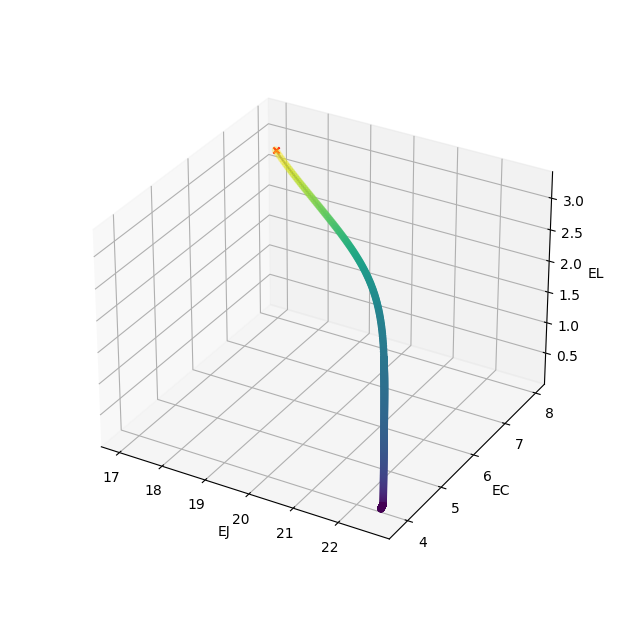

[22.668360617982877, 3.880782408934993, 0.20000000298023224, 7318.539247540196]


In [25]:
import matplotlib as plt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection='3d')
ax.dist = 12
ax.set_xlabel('EJ')
ax.set_ylabel('EC')
ax.set_zlabel('EL')

ax.plot(np.array(EJ_vals), np.array(EC_vals), np.array(EL_vals), 'gray', zorder=1)
ax.scatter(np.array(EJ_vals), np.array(EC_vals), np.array(EL_vals), c=np.array(np.log(cost_vals)), cmap='viridis', marker="o", zorder=2)

ax.scatter(np.array(EJ_vals)[0], np.array(EC_vals)[0], np.array(EL_vals)[0],marker='x',color='r', zorder=3)
plt.colorbar
plt.show()

fig.savefig('Opt.png', bbox_inches='tight')

T1_vals = 1/(np.array(cost_vals) **(2))
i = np.argmax(T1_vals)
print([EJ_vals[i],EC_vals[i],EL_vals[i],T1_vals[i]/1000])


In [69]:
import pickle
pickle.dump([EJ_vals,EC_vals,EL_vals,T1_vals],open("descent_path",'wb'))

C:\Users\dicid\AppData\Local\Temp\ipykernel_8528\550261011.py:52: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = 12


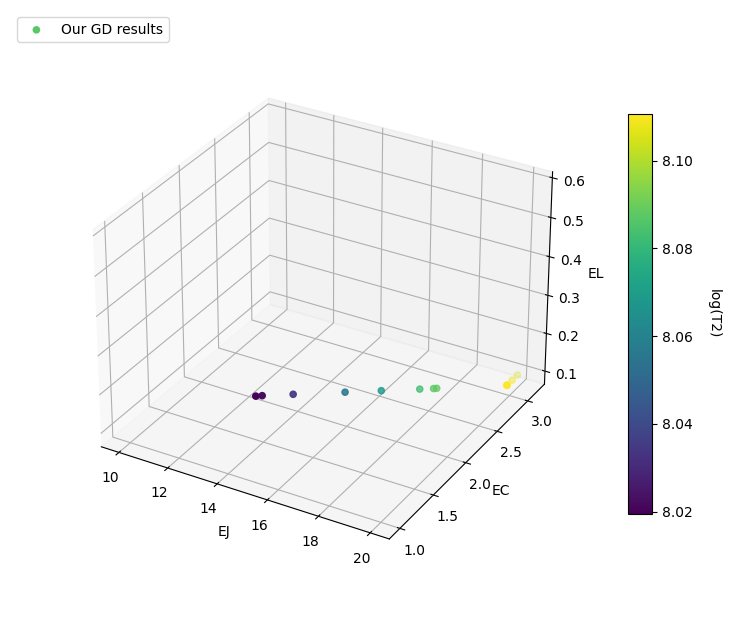

In [114]:
'''
T2_data = np.array(
    [
        [4.206957538, 0.578697433, 0.100000001, 8279.180709] ,
        [6.660502606, 0.958731846, 0.100000001, 8972.952425] ,
        [10.24138516,	1.499055161,	0.100000001	,	9773.851129] ,
        [11.32989198,	1.667641864,	0.100000001	,	9985.612925] ,
        [10.38843831,	1.527081337,	0.100000001	,	9803.797458],
        [10.444682269995816, 1.3352898574965357, 0.10000000149011612, 9543.770359],
        [16.54053246619035, 2.441887318404305, 0.10000000149011612, 10862.364244],
        [11.842823067312413, 1.7450837118794917, 0.10000000149011612, 10081.138565],
        [11.231790309651384, 1.6529915600112972, 0.10000000149011612, 9967.078148],
        [15.789081597465325, 2.1877932618758757, 0.10000000149011612, 10667.388852],
        [14.532569327502943, 2.1510743483357433, 0.10000000149011612, 10546.819161],
        [15.344614925409678, 2.1139673695321326, 0.10000000149011612, 10585.014349],
        [11.88504129707227, 1.5540781168213549, 0.10000000149011612, 9869.579682],
        [12.62559527647197, 1.8652114132232653, 0.10000000149011612, 10222.570563]
    ]
)
'''

T2_data = np.array(
    [
        [17.847053031718467, 2.6332923348207378, 0.10000000149011612, 11056.095359171064],
        [15.249806843335492, 2.2537439719570824, 0.10000000149011612, 10662.211861170212],
        [20.0, 3.0402289538198275, 0.10000000149011612, 11340.297097790146],
        [20.0, 2.9523942672714565, 0.10000000149011612, 11358.36848173217],
        [13.729747791623971, 2.0321301353578884, 0.10000000149011612, 10413.543045174096],
        [17.44059332741193, 2.5741525620413803, 0.10000000149011612, 10996.74340750976],
        [20.0, 2.9521843665509078, 0.10000000149011612, 11358.36658198696],
        [16.3113047120541, 2.40932086911737, 0.10000000149011612, 10827.534471941506],
        [20.0, 3.126843297193342, 0.10000000149011612, 11286.498056756885],
        [20.0, 2.9551836778038134, 0.10000000149011612, 11358.373142604587],
        [17.9361572290813, 2.64855713818781, 0.10000000149011612, 11069.099578286361],
        [12.82891242756478, 1.8983991252887358, 0.10000000149011612, 10258.525019827634],
        [12.650445691158259, 1.868781177771774, 0.10000000149011612, 10226.963344285963]
    ]
)

T2_lit = np.array(
    [
        [10,1,0.58,510]
        #[3.43, 1, 0.58, 510]
    ]
)

import matplotlib as plt
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8,8])
ax = fig.add_subplot(projection='3d')
ax.dist = 12
ax.set_xlabel('EJ')
ax.set_ylabel('EC')
ax.set_zlabel('EL')

EJ_vals = T2_data[:,0]
EC_vals = T2_data[:,1]
EL_vals = T2_data[:,2]
cost_vals = 1/(T2_data[:,3])

sp = ax.scatter(np.array(EJ_vals), np.array(EC_vals), np.array(EL_vals), c=np.array(np.log10(1/cost_vals**2)), cmap='viridis', marker="o",label='Our GD results')

#ax.scatter(T2_lit[:,0], T2_lit[:,1], T2_lit[:,2],marker='x',color='r',label='experimental choice')
ax.scatter(T2_lit[:,0], T2_lit[:,1], T2_lit[:,2],marker='x',color='r',alpha=0)
plt.legend(loc='upper left')
cbar = plt.colorbar(sp,orientation='vertical',cax = fig.add_axes([0.9, 0.25, 0.03, 0.5]))
cbar.set_label('log(T2)', rotation=270, labelpad=20)
plt.show()

fig.savefig('Results.png', bbox_inches='tight')



In [ ]:
# OTHER GRADIENT-BASED METHODS

In [50]:
import scqubits as scq
import scqubits.core.noise as noise
import scqubits.core.units as units
import numpy as np
import torch
from numpy import ndarray
import math

fluxonium = scq.Fluxonium(EJ = 12.62559527647197,
                               EC = 1.8652114132232653,
                               EL = 0.10000000149011612,
                               flux = 0.5,
                               cutoff = 110)

print(fluxonium.t2_effective(get_rate=False)/1000)
t2_effective(torch.tensor(12.62559527647197),torch.tensor(1.8652114132232653),torch.tensor(0.10000000149011612),0.5,110)


2642.041921537232


tensor([[10222570.5558]], dtype=torch.float64)